In [18]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use('fivethirtyeight')

In [47]:
start = '2020-01-01'
end = '2024-02-28'
df = yf.download('KORDS.IS', start=start, end=end)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,13.110000,13.220000,12.950000,13.010000,12.012535,2384830
2020-01-03,13.000000,13.010000,12.420000,12.700000,11.726302,2359639
2020-01-06,12.600000,12.600000,12.140000,12.160000,11.227704,1513861
2020-01-07,12.270000,12.480000,12.270000,12.390000,11.440071,1155714
2020-01-08,12.180000,12.470000,12.010000,12.420000,11.467770,1270918
...,...,...,...,...,...,...
2024-02-21,91.300003,91.599998,89.500000,90.349998,90.349998,1376337
2024-02-22,90.699997,92.550003,90.349998,92.400002,92.400002,1281300
2024-02-23,92.750000,96.099998,92.599998,95.750000,95.750000,2709253


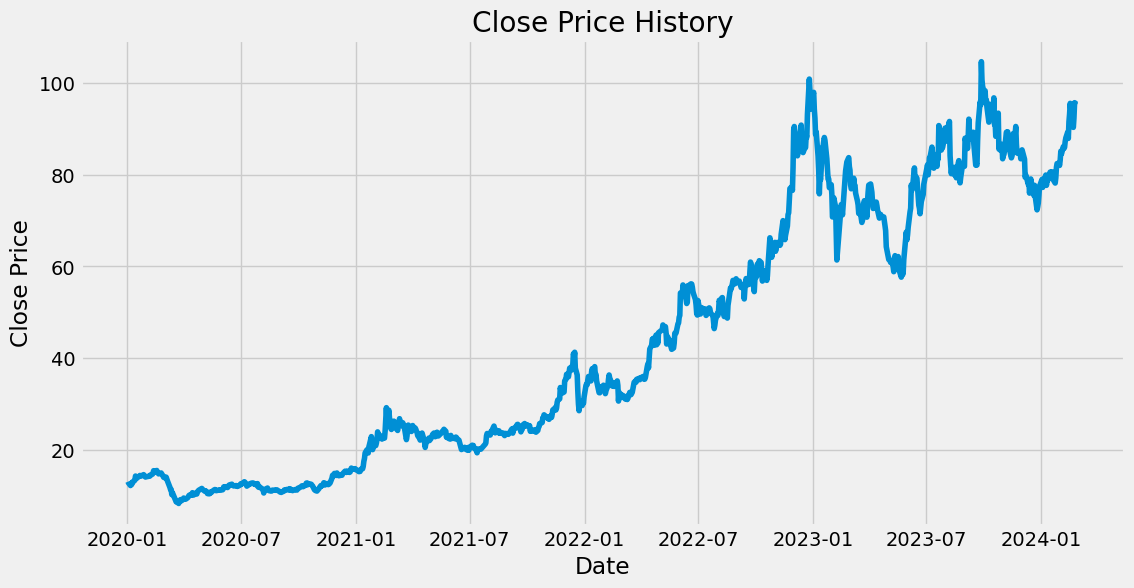

In [48]:
# kapanış verisini tarihe göre görselleştir
plt.figure(figsize=(12, 6))
plt.title("Close Price History")
plt.plot(df['Close'])
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.show()

In [49]:
# kapanış verisini filtrele
data = df.filter(['Close'])
# numpy dizisini dönüştür
dataset = data.values
# eğitim seti oluştur %80'lik
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

835

In [50]:
# veriyi ölçeklendir
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.04945056],
       [0.04623678],
       [0.04063861],
       ...,
       [0.90721546],
       [0.90358702],
       [0.90306864]])

In [51]:
# eğitim veri seti oluştur
# ölçeklendirilmiş eğitim seti oluştur
train_data = scaled_data[0: training_data_len, :]
# X_train and y_train olarak veriyi ikiye böl
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [52]:
#  iki seti de numpy dizisine dönüştür
X_train, y_train = np.array(X_train), np.array(y_train)

In [53]:
# 3-boyutlu olacak şekilde veriyi yeniden şekillendir
display(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
display(X_train.shape)

(775, 60)

(775, 60, 1)

In [54]:
# LSTM modelini oluştur
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [55]:
# model derleme
model.compile(optimizer='adam', loss='mean_squared_error')

In [56]:
# model eğtimi
model.fit(X_train, y_train, batch_size=1, epochs=1)

775/775 [==============================] - 15s 15ms/step - loss: 0.0026


In [57]:
# test setlerini oluştur
# ölçeklenidirlmiş değerlerle yeni bir dizi oluştur
test_data = scaled_data[training_data_len - 60:, :]
X_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

In [58]:
# veriyi numpy dizisine dönüştür
X_test = np.array(X_test)
# 3-boyutlu olacak şekilde veriyi yeniden şekillendir
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [59]:
# modelin tahminlerini ölçeklenmiş olduğundan bu ölçekleri geri al
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

7/7 [==============================] - 1s 14ms/step


In [60]:
# modelin yorumlanması
# RMSE'nin kullanılması
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

2.000919323701125

C:\Users\rafon\AppData\Local\Temp\ipykernel_12080\1461330667.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


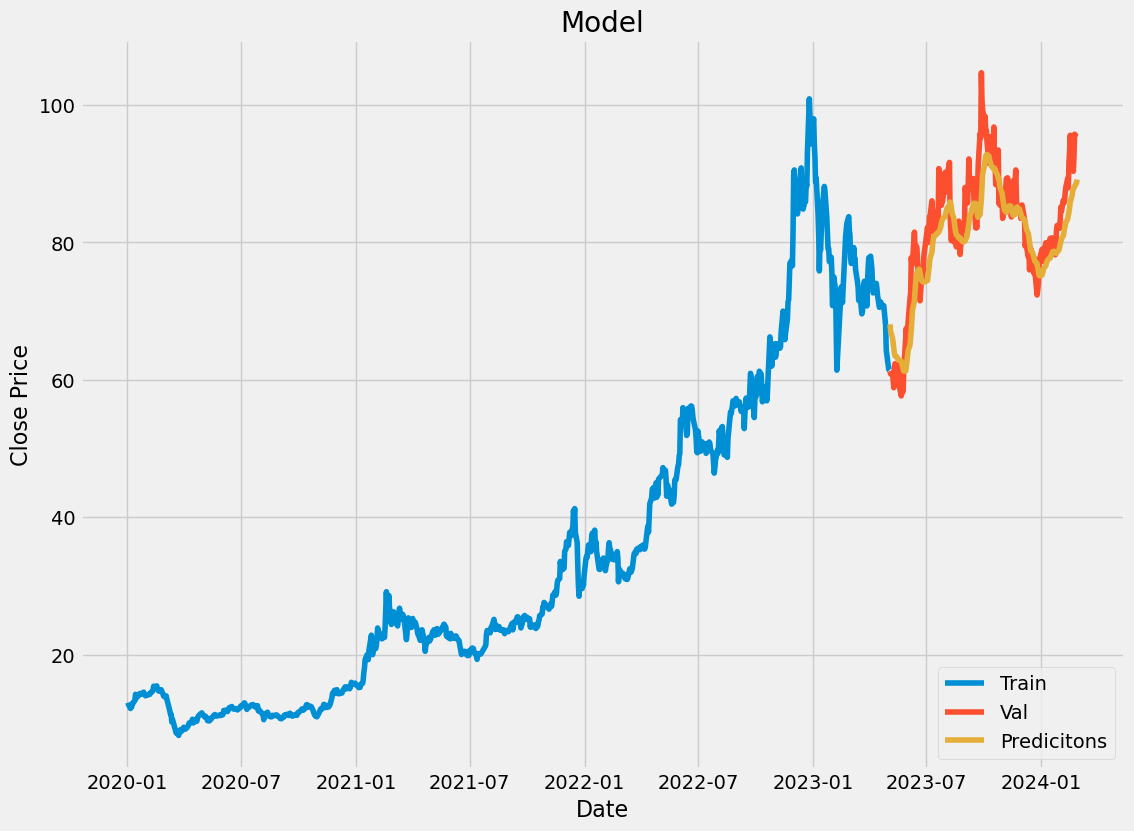

In [61]:
# görselleştrime
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(12,9))
plt.title('Model')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price', fontsize=16)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predicitons'], loc='lower right')
plt.show()